In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

In [2]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import imgaug as ia
import random

from pathlib import Path
from numpy import asarray
from imgaug import augmenters as iaa
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

In [3]:
train_data_path = '../../sensix_daninhas/dataset/train'
validation_data_path  = '../../sensix_daninhas/dataset/validation'

img_rows = 100
img_cols = 100
epochs = 200
batch_size = 20
n_channels = 3

In [4]:
num_of_train_samples = sum(len(files) for _, _, files in os.walk(train_data_path))
num_of_validation_samples  = sum(len(files) for _, _, files in os.walk(validation_data_path))
print("Train Images : ", num_of_train_samples)
print("Validation Images  : ", num_of_validation_samples)

Train Images :  2925
Validation Images  :  820


In [5]:
def random_func(*, percentage: int) -> int:
    '''
    percentage: Valores entre 0 e 100. Caso percentage > _value é retornado true, caso não
    é retornado false
    
    description: Utilizada para definir se a função de pré processamento será utilizada ou
    não. 
    
    return:
    bool
    '''
    _value = random.randint(0, 100)
    if _value < percentage:
        #print(_value)
        return False
    else:
        #print(_value)
        return True

In [6]:
def prepare_dataset_func_1(img):
    '''
    img: array que representa a imagem que será modificada:
    
    description: Representa efeitos relacionados a coloração da imagem. Nenhuma
    rotação ou aproximação (zoom) é dado. Apenas possui filtros que alteram as 
    caracteristicas gerais das imagens
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    if random_func(percentage = 10):
        seq = iaa.Sequential([
            #iaa.Affine(rotate=(0, 90)),
            #iaa.Crop(percent=(0.1, 0.2)),
            iaa.LinearContrast((1.0, 1.9)),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.AdditiveGaussianNoise(scale=(10, 20)),
            #iaa.Crop(percent=(0, 0.2)),
            iaa.AddToBrightness((-30, 30)),
            iaa.AddToHue((-50, 50)),
            #iaa.flip.Fliplr(0.5)
            #iaa.AllChannelsHistogramEqualization()
        ],
        random_order=True)
        images_aug = seq(image=img)
    else:
        images_aug = img
    
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [7]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

In [8]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   preprocessing_function=prepare_dataset_func_1,
                                   fill_mode='constant',
                                   )

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  )


train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    )

validation_generator = test_datagen.flow_from_directory(validation_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        )

Found 2925 images belonging to 2 classes.
Found 820 images belonging to 2 classes.


In [9]:
reset_random_seeds()

visible = tf.keras.layers.Input(shape=(img_rows, img_cols, n_channels))
conv1 = tf.keras.layers.Conv2D(8, (3,3), activation='relu')(visible)
pooling1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
conv2 = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(pooling1)
pooling2 = tf.keras.layers.MaxPooling2D(2,2)(conv2)
conv3 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(pooling2)
pooling3 = tf.keras.layers.MaxPooling2D(2,2)(conv3)
flat = tf.keras.layers.Flatten()(pooling3)
hidden1 = tf.keras.layers.Dense(64, activation='relu')(flat)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hidden1)

model = tf.keras.Model(inputs=visible, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0     

In [10]:
class CallbackStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        _percent = 0.99
        tf.keras.callbacks.TensorBoard(log_dir='logs')
        if logs.get('val_accuracy') is not None and logs.get('accuracy') and logs.get('val_accuracy') > _percent and logs.get('accuracy') > _percent:
            print("\nO treino foi cancelado, obtido mais de",_percent," de accuracy!", "\n")
            self.model.stop_training = True

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

callbacks = CallbackStop()

history = model.fit(train_generator,
                    steps_per_epoch= num_of_train_samples // batch_size,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=num_of_validation_samples // batch_size,
                    callbacks=[callbacks]
                    )

Epoch 1/100
146/146 [==============================] - 15s 98ms/step - loss: 0.3340 - accuracy: 0.8667 - val_loss: 0.2816 - val_accuracy: 0.8220
Epoch 2/100
146/146 [==============================] - 14s 96ms/step - loss: 0.1904 - accuracy: 0.9133 - val_loss: 0.2902 - val_accuracy: 0.7902
Epoch 3/100
146/146 [==============================] - 14s 96ms/step - loss: 0.1760 - accuracy: 0.9188 - val_loss: 0.7570 - val_accuracy: 0.8622
Epoch 4/100
146/146 [==============================] - 14s 96ms/step - loss: 0.2061 - accuracy: 0.9286 - val_loss: 0.2126 - val_accuracy: 0.8598
Epoch 5/100
146/146 [==============================] - 14s 95ms/step - loss: 0.1731 - accuracy: 0.9170 - val_loss: 0.2595 - val_accuracy: 0.8232
Epoch 6/100
146/146 [==============================] - 14s 95ms/step - loss: 0.1766 - accuracy: 0.9174 - val_loss: 0.2017 - val_accuracy: 0.8707
Epoch 7/100
146/146 [==============================] - 14s 95ms/step - loss: 0.1638 - accuracy: 0.9253 - val_loss: 0.2366 - val_ac

146/146 [==============================] - 14s 95ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.0894 - val_accuracy: 0.9646
Epoch 58/100
146/146 [==============================] - 14s 95ms/step - loss: 0.0544 - accuracy: 0.9802 - val_loss: 0.1275 - val_accuracy: 0.9415
Epoch 59/100
146/146 [==============================] - 14s 95ms/step - loss: 0.0467 - accuracy: 0.9881 - val_loss: 0.1347 - val_accuracy: 0.9268
Epoch 60/100
146/146 [==============================] - 14s 95ms/step - loss: 0.0751 - accuracy: 0.9742 - val_loss: 0.0656 - val_accuracy: 0.9744
Epoch 61/100
146/146 [==============================] - 14s 95ms/step - loss: 0.0558 - accuracy: 0.9842 - val_loss: 0.1056 - val_accuracy: 0.9598
Epoch 62/100
146/146 [==============================] - 14s 95ms/step - loss: 0.0571 - accuracy: 0.9826 - val_loss: 0.0731 - val_accuracy: 0.9695
Epoch 63/100
146/146 [==============================] - 14s 96ms/step - loss: 0.0410 - accuracy: 0.9878 - val_loss: 0.0930 - val_accuracy

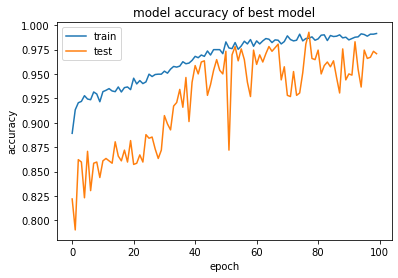

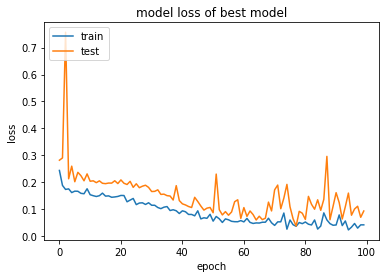

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of best model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of best model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
#image_path = '../../sensix_daninhas/ortomosaicos/pos-emergente/test2/nao'
#image_path = '../../sensix_daninhas/datasetpericles/test/'
image_path = '../../sensix_daninhas/gabarito_nao/'


images = []

for img in os.listdir(image_path):
        img = os.path.join(image_path, img)
        img = image.load_img(img, target_size=(100,100))
        img = image.img_to_array(img)
        #print(img)
        img = np.expand_dims(img, axis=0)
        processed_image = np.array(img, dtype="float")
        images.append(processed_image)
        
images = np.vstack(images)
print(len(images))

69


count_daninha 31
count_sem_daninha 38


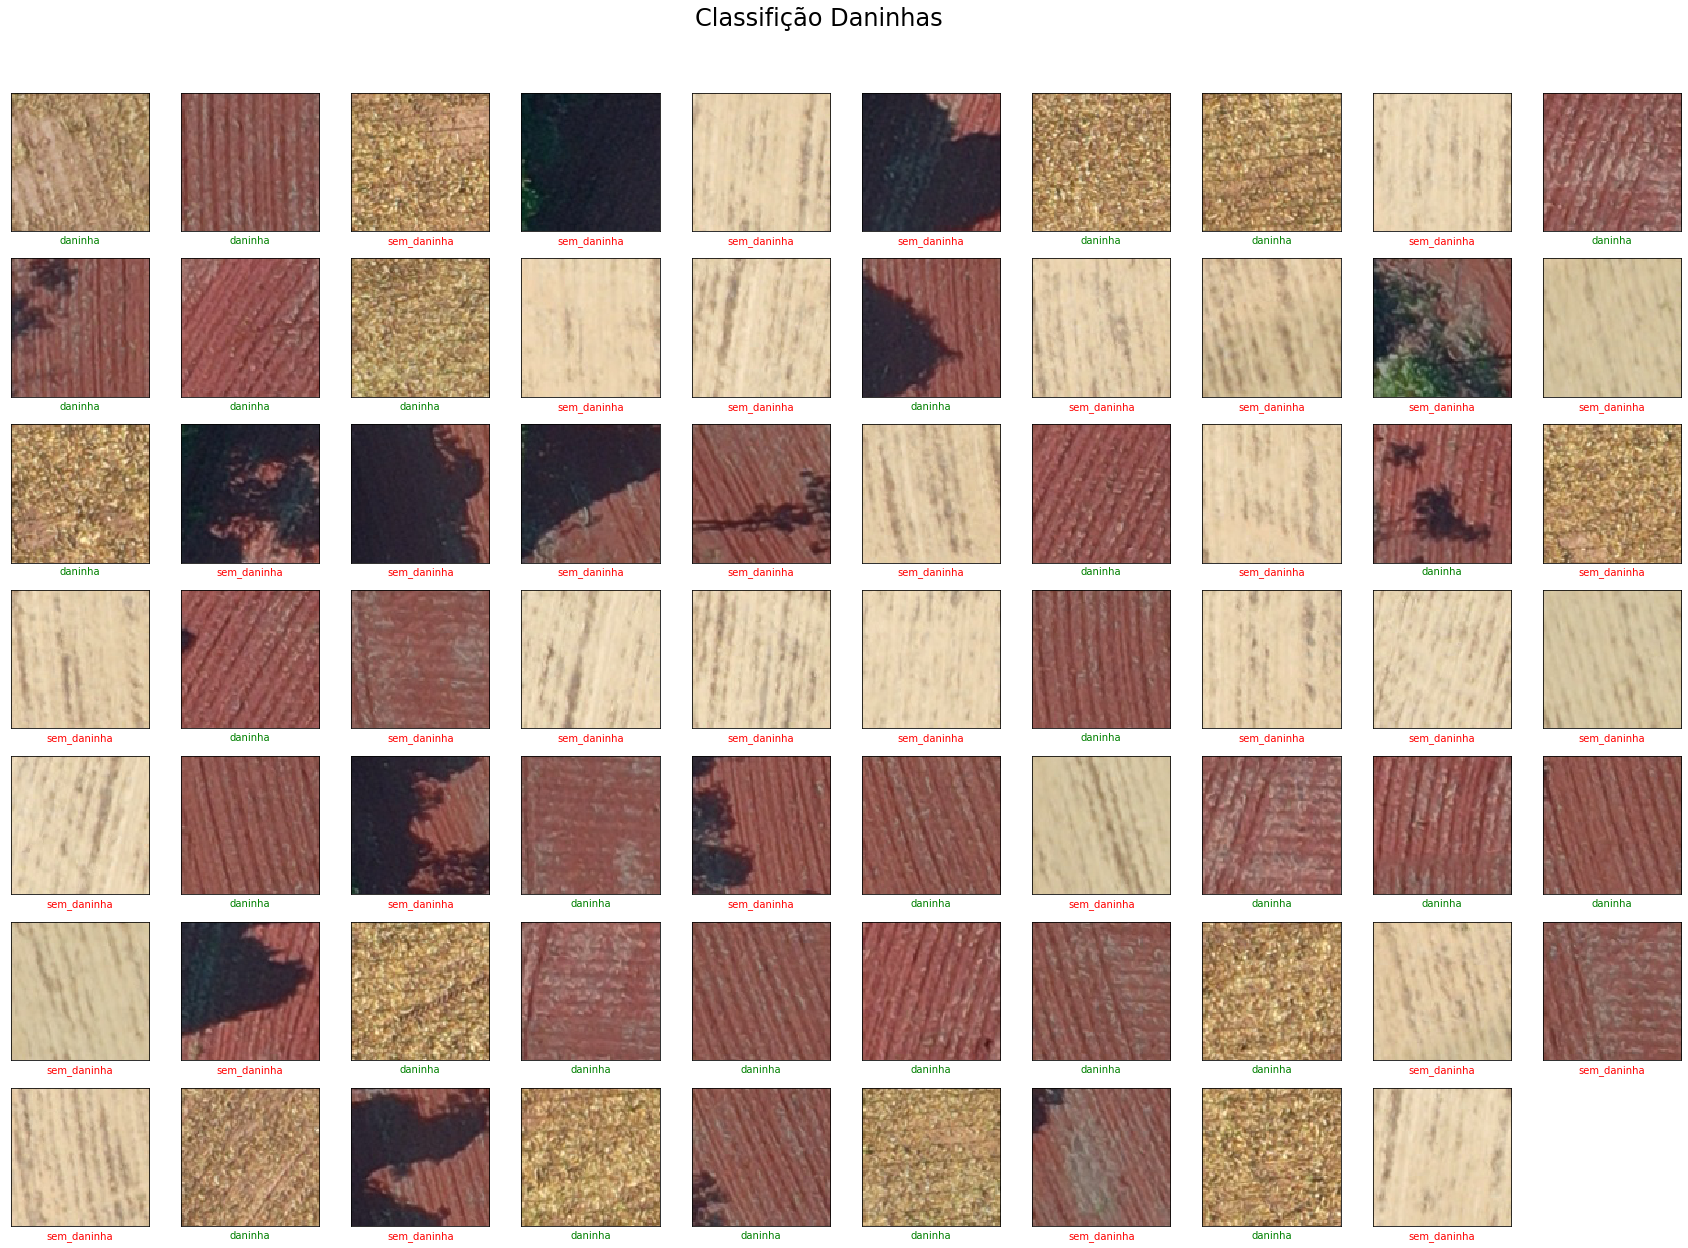

In [19]:
images_data = []
filenames = []
count_daninha = 0
count_sem_daninha = 0
count = 0
pred_result = model.predict(images)
#print(pred_result)
plt.figure(figsize=(30,30))
grid_size = min(0, len(pred_result))

for filename in os.listdir(image_path):
    images_data.append(pred_result)
    filenames.append(filename)
    plt.subplot(10, 10, count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[count].astype(np.int32), cmap=plt.cm.binary)
    if pred_result[count] > 0.5:
        legend_x = plt.xlabel("daninha")
        legend_x.set_color("green")
        count_daninha = count_daninha + 1
        if count >= num_of_validation_samples:
            break
    else :
        legend_x = plt.xlabel("sem_daninha")
        legend_x.set_color("red")
        count_sem_daninha = count_sem_daninha + 1
    count += 1

print("count_daninha", count_daninha)
print("count_sem_daninha", count_sem_daninha)
plt.suptitle('Classifição Daninhas', y = 0.92, fontsize=24)
plt.show(images_data)